In [192]:
# librarires ---- 

import pandas as pd
import numpy as np
import yfinance as yf
from prettytable import PrettyTable
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# basic functions ----

def load_data(ticker_name, start_date):
    return yf.download(ticker_name, start_date)

    
# investment

def annual_return(ticker_name, start_date):
    data = load_data(ticker_name, start_date)
    data['total_returns'] = data['Adj Close'].pct_change()
    annual_return = data.total_returns.mean()*252*100
    return round(annual_return, 1)
    
def annual_volatility(ticker_name, start_date):
    data = load_data(ticker_name, start_date)
    data['total_returns'] = data['Adj Close'].pct_change()
    annual_volatility = data.total_returns.std() * np.sqrt(252) * 100
    return round(annual_volatility, 1)

def vis_close_price(ticker_name, start_date):
    data = load_data(ticker_name, start_date)
    data['Close'].plot(figsize=(15,7))
    plt.ylabel('Close Price')
    plt.title('{} Close Price'.format(ticker_name))
    plt.show()

# swing trading

def calc_trade_returns(ticker_name, start_date, model):
    data = model(ticker_name, start_date)
    data['returns'] = data.Close.pct_change()
    data['trade_returns'] = data.returns * data.trading_signal.shift(1)
    return data

def trade_return(ticker_name, start_date):
    cumulative_trade_returns = (data.trade_returns + 1).cumprod()
    days = len(cumulative_trade_returns)
    annual_returns = (cumulative_trade_returns.iloc[-1]**(252/days) - 1)*100
    return round(annual_returns, 1)

def trade_volatility(ticker_name, start_date):
    annual_volatility = data.trade_returns.std() * np.sqrt(252) * 100
    return round(annual_volatility, 1)
    

def vis_trade_return(ticker_name, start_date, model):
    cumulative_trade_returns = (data.trade_returns + 1).cumprod()
    cumulative_trade_returns.plot(figsize=(15,7))
    plt.ylabel('Cumulative Returns')
    plt.title('Cumulative Returns of {} Strategy on {}'.format(model.__name__, ticker_name))
    plt.show()
    
    
# summary ----

def sum_table(ticker_name, start_date, model_lst):
    myTable = PrettyTable(["Strategy", "Annualized Return (%)", "Annualized Volatility (%)"])
    myTable.add_row(["Investment", annual_return(ticker_name, start_date), annual_volatility(ticker_name, start_date)])
    global data, hybrid
    for i, model in enumerate(model_lst):
        data = calc_trade_returns(ticker_name, start_date, model)
        myTable.add_row([model.__name__, trade_return(ticker_name, start_date), trade_volatility(ticker_name, start_date)])
        if i == 0:
            hybrid = data[['Close','trading_signal']]
        else:
            hybrid = hybrid.merge(data[['trading_signal']], left_index=True, right_index=True, how = "outer")
    data = hybrid
    data['hybrid'] = np.where((data[list(data.filter(like='trading_signal').columns)] == 1).all(axis=1), 1, np.nan)
    data['hybrid'] = np.where((data[list(data.filter(like='trading_signal').columns)] == -1).all(axis=1), -1, data['hybrid'])
    data = data.drop(columns = list(data.filter(like='trading_signal').columns))
    data.columns = ['Close', 'trading_signal']
    data = data.fillna(method = 'ffill')
    data['returns'] = data.Close.pct_change()
    data['trade_returns'] = data.returns * data.trading_signal.shift(1)
    myTable.add_row(["Hybrid", trade_return(ticker_name, start_date), trade_volatility(ticker_name, start_date)])
    return myTable

def sum_vis(ticker_name, start_date, model_lst):
    vis_close_price(ticker_name, start_date)
    global data, hybrid
    for i, model in enumerate(model_lst):
        data = calc_trade_returns(ticker_name, start_date, model)
        vis_trade_return(ticker_name, start_date, model)
        if i == 0:
            hybrid = data[['Close','trading_signal']]
        else:
            hybrid = hybrid.merge(data[['trading_signal']], left_index=True, right_index=True, how = "outer")
    data = hybrid
    data['hybrid'] = np.where((data[list(data.filter(like='trading_signal').columns)] == 1).all(axis=1), 1, np.nan)
    data['hybrid'] = np.where((data[list(data.filter(like='trading_signal').columns)] == -1).all(axis=1), -1, data['hybrid'])
    data = data.drop(columns = list(data.filter(like='trading_signal').columns))
    data.columns = ['Close', 'trading_signal']
    data = data.fillna(method = 'ffill')
    data['returns'] = data.Close.pct_change()
    data['trade_returns'] = data.returns * data.trading_signal.shift(1)
    vis_trade_return(ticker_name, start_date, Hybrid)
    
# models ----

def MACD(ticker_name, start_date):
    data = load_data(ticker_name, start_date)
    data['12d_EMA'] = data.Close.ewm(span=12, adjust=False).mean()
    data['26d_EMA'] = data.Close.ewm(span=26, adjust=False).mean()
    data['macd'] = data['12d_EMA']- data['26d_EMA'] 
    data['macdsignal'] = data.macd.ewm(span=9, adjust=False).mean()
    data['trading_signal'] = np.nan
    data.loc[data['macd'] > data['macdsignal'], 'trading_signal'] = 1
    data.loc[data['macd'] < data['macdsignal'], 'trading_signal'] = -1
    data = data.fillna(method = 'ffill')
    return data

def SMA(ticker_name, start_date):
    data = load_data(ticker_name, start_date)
    data['10d_SMA'] = data.Close.rolling(window=10).mean()
    data['50d_SMA'] = data.Close.rolling(window=20).mean()
    data['trading_signal'] = np.nan
    data.loc[data['10d_SMA'] > data['50d_SMA'], 'trading_signal'] = 1
    data.loc[data['10d_SMA'] < data['50d_SMA'], 'trading_signal'] = -1
    data = data.fillna(method = 'ffill')
    return data

def calc_RSI (data, time_window=14):
    diff = data.diff(1).dropna()       
    up_chg = 0 * diff
    down_chg = 0 * diff
    up_chg[diff > 0] = diff[diff>0]
    down_chg[diff < 0] = diff[diff < 0]
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi
    return RSI

def RSI(ticker_name, start_date, window=14):
    data = load_data(ticker_name, start_date)
    data['RSI'] = calc_RSI(data['Adj Close'], 14)
    data['trading_signal'] = np.nan
    data.loc[data['RSI'] < 30, 'trading_signal'] = 1
    data.loc[data['RSI'] > 70, 'trading_signal'] = -1
    data = data.fillna(method = 'ffill')
    return data

def Hybrid():
    pass

In [213]:
sum_table('WMT', '2012-1-1', [MACD, SMA, RSI])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Strategy,Annualized Return (%),Annualized Volatility (%)
Investment,12.2,20.2
MACD,-4.4,20.3
SMA,-2.2,20.3
RSI,10.8,20.3
Hybrid,2.5,20.3


[*********************100%***********************]  1 of 1 completed


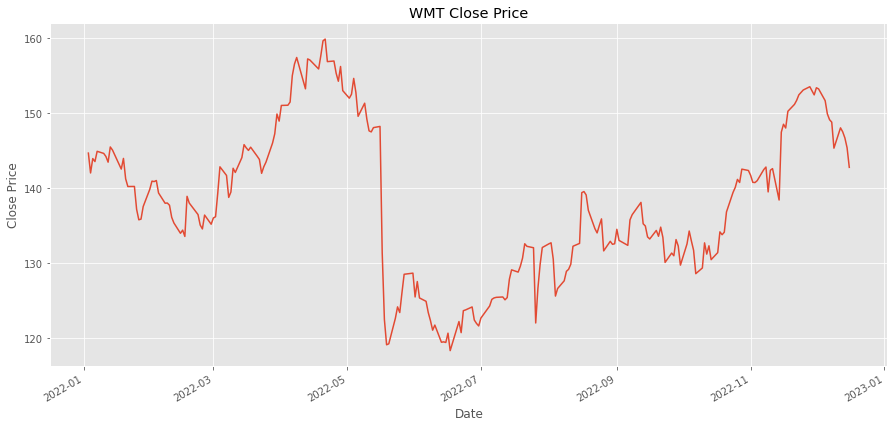

[*********************100%***********************]  1 of 1 completed


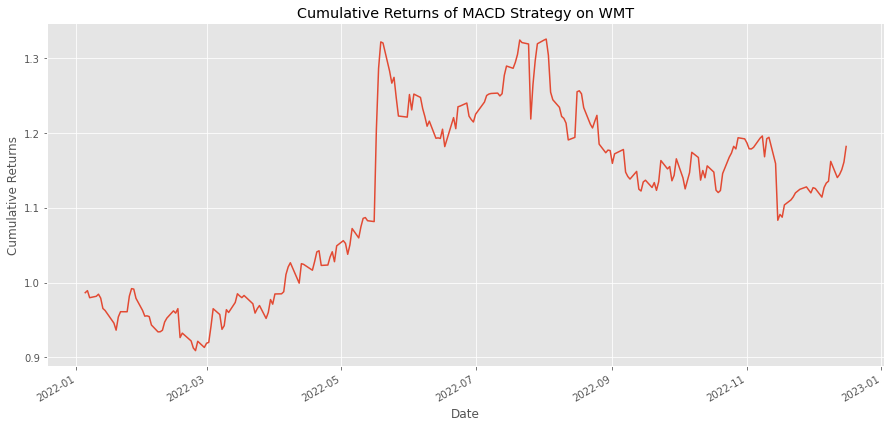

[*********************100%***********************]  1 of 1 completed


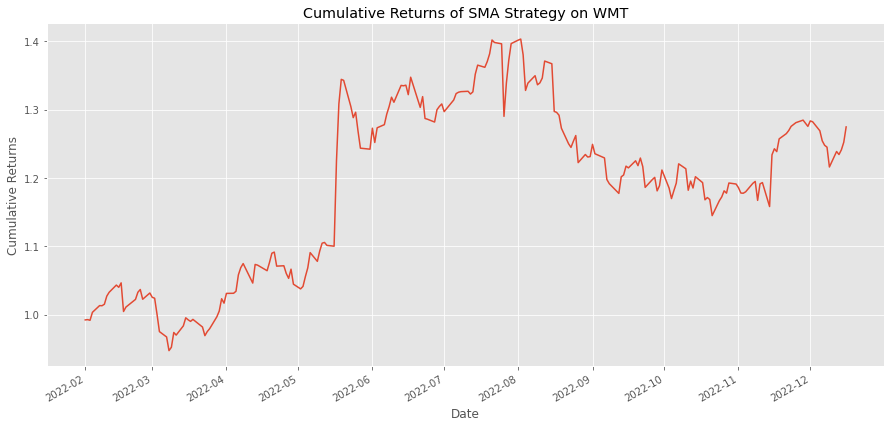

[*********************100%***********************]  1 of 1 completed


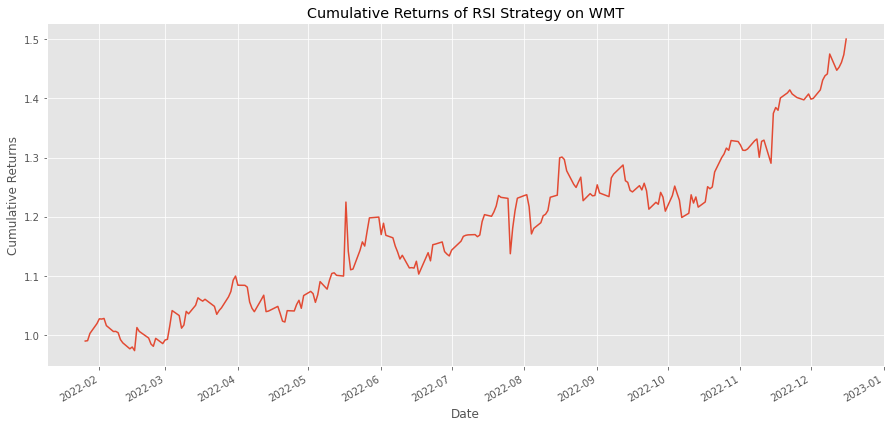

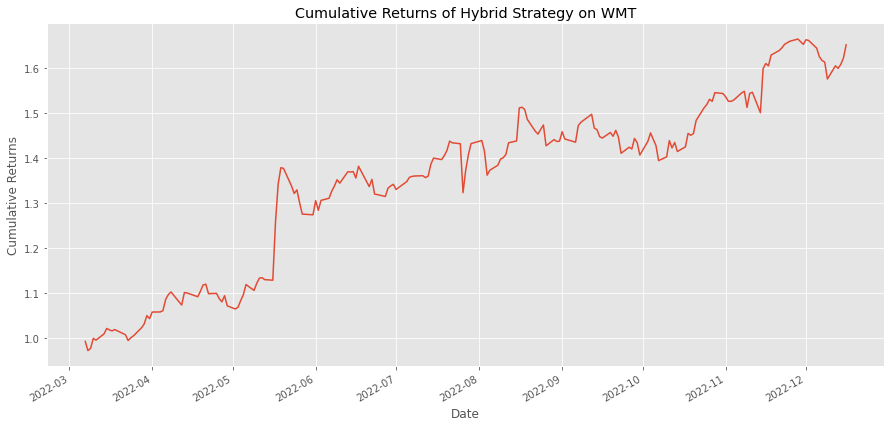

In [214]:
sum_vis('WMT', '2022-1-1', [MACD, SMA, RSI])